In [8]:
using StanSample, Statistics, PyPlot, Random, Distributions, LinearAlgebra

In [42]:
p = 3;
SIGMA = diagm(rand(Uniform(),p))

eig = rand(Uniform(),p)
Z = rand(Normal(),p,p)
Q,R = qr(Z)
d = diag(R)
ph = d ./ abs.(d)
O = Q * diagm(ph)
PHI = transpose(O) * diagm(eig) * O;

In [43]:
T = 200
y0 = rand(Normal(),p)
Y = zeros(p,T)
Y[:,1] = y0

for i in 2:T
    Y[:,i] = PHI * Y[:,i-1] + rand(MvNormal(zeros(3),SIGMA))
end

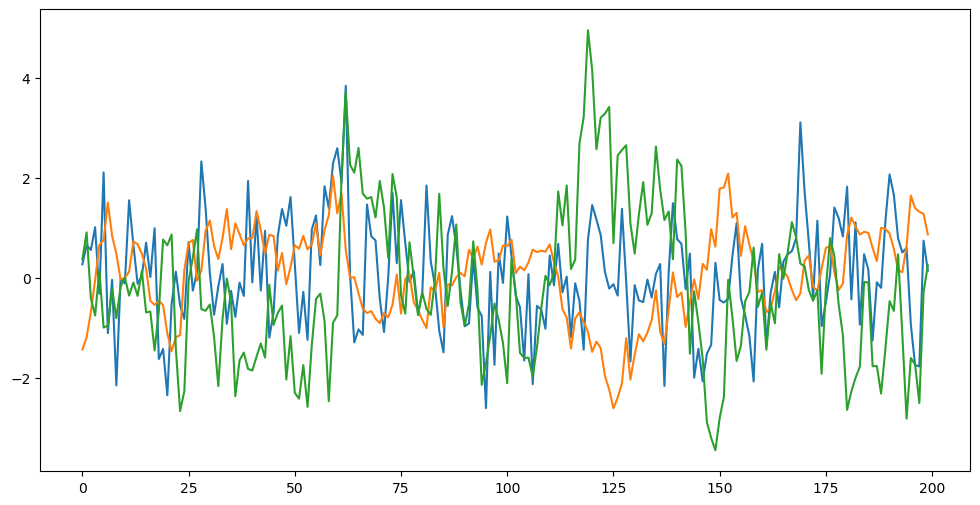

In [45]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(transpose(Y));

In [46]:
mod_code = "data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
    matrix[p,p] PHI;     //dynamics matrix
    vector<lower=1E-15>[p] sigma;     //variances of stochastic forcing
    vector[p] init;      //mean of initial conditions as parameter vector
}
model{
    Y[,1] ~ normal(init, sigma);           //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma); //conditional predictive distribution
    }
}";

In [47]:
data = Dict("p" => p, "T" => T, "Y" => Y)

Dict{String,Any} with 3 entries:
  "Y" => [0.274358 0.655854 … 0.746856 0.144656; -1.42712 -1.1811 … 1.28196 0.8…
  "T" => 200
  "p" => 3

In [49]:
sm = SampleModel("MV_AR", mod_code)


/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_xQchHu/MV_AR.stan updated.


  name =                    "MV_AR"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_xQchHu"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [50]:
(sample_file, log_file) = stan_sample(sm, data=data, n_chains = 4);

In [51]:
chns = read_samples(sm)

Object of type Chains, with data of type 1000×22×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = PHI.1.1, PHI.2.1, PHI.3.1, PHI.1.2, PHI.2.2, PHI.3.2, PHI.1.3, PHI.2.3, PHI.3.3, sigma.1, sigma.2, sigma.3, init.1, init.2, init.3

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean      │ std       │ naive_se    │ mcse        │
│     │ Symbol     │ Float64   │ Float64   │ Float64     │ Float64     │
├─────┼────────────┼───────────┼───────────┼─────────────┼─────────────┤
│ 1   │ PHI.1.1    │ 0.331223  │ 0.0681086 │ 0.00107689  │ 0.000917875 │
│ 2   │ PHI.2.1    │ 0.0932414 │ 0.0228288 │ 0.000360954 │ 0.000311015 │
│ 3   │ PHI.3.1    │ 0.0209556 │ 0.0644458 │ 0.00101898  │ 0.000832997 │
│ 4   │ PHI.1.2    │ 0.112545  │ 0.104936  │ 0.0

In [52]:
ESS = ess(chns)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ PHI.1.1    │ 5929.86 │ 0.999478 │
│ 2   │ PHI.2.1    │ 6460.23 │ 0.999648 │
│ 3   │ PHI.3.1    │ 6012.33 │ 0.999528 │
│ 4   │ PHI.1.2    │ 4939.29 │ 0.999309 │
│ 5   │ PHI.2.2    │ 4400.23 │ 0.999357 │
│ 6   │ PHI.3.2    │ 4188.04 │ 0.999943 │
│ 7   │ PHI.1.3    │ 4561.06 │ 0.999278 │
│ 8   │ PHI.2.3    │ 4129.11 │ 1.00045  │
│ 9   │ PHI.3.3    │ 4151.59 │ 0.999949 │
│ 10  │ sigma.1    │ 6789.71 │ 0.999269 │
│ 11  │ sigma.2    │ 7249.19 │ 0.999318 │
│ 12  │ sigma.3    │ 6597.89 │ 1.00035  │
│ 13  │ init.1     │ 6655.12 │ 0.999285 │
│ 14  │ init.2     │ 6521.01 │ 0.999692 │
│ 15  │ init.3     │ 7691.58 │ 0.999538 │

### Investigating the stochastic forcing matrix
Here we relax the assumption of independent forcing

In [55]:
A = rand(Uniform(),p,p) .* 2 .- 1
SIGMA2 = transpose(A) * A

3×3 Array{Float64,2}:
  1.22019   -0.267171   0.801672
 -0.267171   0.586635  -0.257389
  0.801672  -0.257389   0.71493 

In [59]:
T = 200
y20 = rand(Normal(),p)
Y2 = zeros(p,T)
Y2[:,1] = y20

for i in 2:T
    Y2[:,i] = PHI * Y2[:,i-1] + rand(MvNormal(zeros(3),SIGMA2))
end

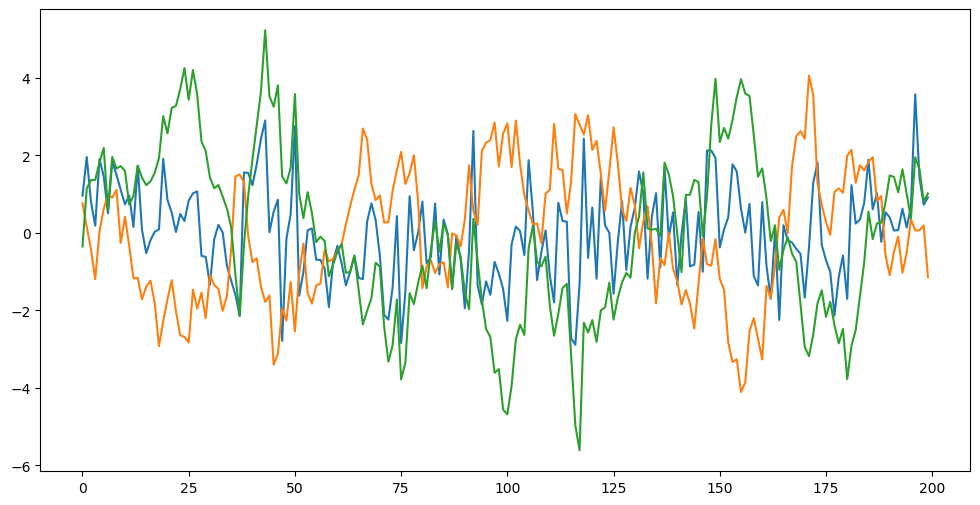

In [60]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(transpose(Y2));

In [61]:
mod_code_cov = "data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
    matrix[p,p] PHI;     //dynamics matrix
    cov_matrix[p] SIGMA; //co-variance matrix of stochastic forcing
    vector[p] init;      //mean of initial conditions as parameter vector
}
model{
    Y[,1] ~ multi_normal(init, SIGMA);           //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ multi_normal(PHI*Y[,i-1],SIGMA); //conditional predictive distribution
    }
}";

In [62]:
data2 = Dict("p" => p, "T" => T, "Y" => Y2)

Dict{String,Any} with 3 entries:
  "Y" => [0.958626 1.95742 … 0.726208 0.914786; 0.767086 0.156097 … 0.191696 -1…
  "T" => 200
  "p" => 3

In [63]:
sm2 = SampleModel("MV_AR2", mod_code_cov)


/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_oyPEaj/MV_AR2.stan updated.


  name =                    "MV_AR2"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_oyPEaj"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [64]:
(sample_file, log_file) = stan_sample(sm2, data=data2, n_chains = 4);

In [65]:
chns2 = read_samples(sm2)

Object of type Chains, with data of type 1000×28×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = PHI.1.1, PHI.2.1, PHI.3.1, PHI.1.2, PHI.2.2, PHI.3.2, PHI.1.3, PHI.2.3, PHI.3.3, SIGMA.1.1, SIGMA.2.1, SIGMA.3.1, SIGMA.1.2, SIGMA.2.2, SIGMA.3.2, SIGMA.1.3, SIGMA.2.3, SIGMA.3.3, init.1, init.2, init.3

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean      │ std       │ naive_se    │ mcse        │
│     │ Symbol     │ Float64   │ Float64   │ Float64     │ Float64     │
├─────┼────────────┼───────────┼───────────┼─────────────┼─────────────┤
│ 1   │ PHI.1.1    │ 0.240956  │ 0.0874553 │ 0.00138279  │ 0.00241804  │
│ 2   │ PHI.2.1    │ 0.0218175 │ 0.0612854 │ 0.000969007 │ 0.00128157  │
│ 3   │ PHI.3.1    │ 0.138008  │ 0.0678022 │ 0.00

In [66]:
ESS2 = ess(chns2)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ PHI.1.1    │ 2044.68 │ 1.00249  │
│ 2   │ PHI.2.1    │ 2356.99 │ 1.0021   │
│ 3   │ PHI.3.1    │ 2005.67 │ 1.00208  │
│ 4   │ PHI.1.2    │ 1643.89 │ 1.00381  │
│ 5   │ PHI.2.2    │ 1945.58 │ 1.00294  │
│ 6   │ PHI.3.2    │ 1617.89 │ 1.00374  │
│ 7   │ PHI.1.3    │ 1496.97 │ 1.00352  │
│ 8   │ PHI.2.3    │ 1597.03 │ 1.00272  │
│ 9   │ PHI.3.3    │ 1385.33 │ 1.00358  │
│ 10  │ SIGMA.1.1  │ 2863.94 │ 1.00034  │
│ 11  │ SIGMA.2.1  │ 3717.92 │ 1.00035  │
│ 12  │ SIGMA.3.1  │ 2625.13 │ 1.00026  │
│ 13  │ SIGMA.1.2  │ 3717.92 │ 1.00035  │
│ 14  │ SIGMA.2.2  │ 4949.61 │ 0.99997  │
│ 15  │ SIGMA.3.2  │ 4057.71 │ 1.00006  │
│ 16  │ SIGMA.1.3  │ 2625.13 │ 1.00026  │
│ 17  │ SIGMA.2.3  │ 4057.71 │ 1.00006  │
│ 18  │ SIGMA.3.3  │ 2815.9  │ 1.00004  │
│ 19  │ init.1     │ 2960.47 │ 0.999473 │
│ 20  │ init.2     │ 4022.3  │ 0.999468 │
│ 21  │ init.3     │ 3035.36 

### Incorporating a priori structure on the dynamics
The Stan code below imposes the following structure on $\mathbf{\Phi}$:

$$ \mathbf{\Phi} = \begin{bmatrix} \phi_{1,1} & \phi_{1,2} & 0 \\ 
                                \phi_{2,1} & \phi_{2,2} & \phi_{2,3}\\
                                0       & \phi_{3,2} & \phi_{3,3} \end{bmatrix} $$

In [67]:
mod_code_D_struc = "data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
}
parameters{
    matrix[p,p] PHI;               //dynamics matrix
    vector<lower=1E-15>[p] sigma;  //variances of stochastic forcing
    vector[p] init;                //mean of initial conditions as parameter vector
}
model{
    PHI[1,3] ~ normal(0,1E-3);
    PHI[3,1] ~ normal(0,1E-3);

    Y[,1] ~ normal(init, sigma);           //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma); //conditional predictive distribution
    }
}";

In [68]:
sm3 = SampleModel("MV_AR3", mod_code_D_struc)


/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_ivvr0U/MV_AR3.stan updated.


  name =                    "MV_AR3"
  n_chains =                4
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  tmpdir =                  "/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_ivvr0U"
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  StanSample.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                      10.0
      init_buffer =             75
      term_buffer =             50
      window =                  25


In [69]:
(sample_file, log_file) = stan_sample(sm3, data=data, n_chains = 4);

In [70]:
chns3 = read_samples(sm3)

Object of type Chains, with data of type 1000×22×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = PHI.1.1, PHI.2.1, PHI.3.1, PHI.1.2, PHI.2.2, PHI.3.2, PHI.1.3, PHI.2.3, PHI.3.3, sigma.1, sigma.2, sigma.3, init.1, init.2, init.3

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 2 columns
│ Row │ parameters │ mean       │ std         │ naive_se    │ mcse        │
│     │ Symbol     │ Float64    │ Float64     │ Float64     │ Float64     │
├─────┼────────────┼────────────┼─────────────┼─────────────┼─────────────┤
│ 1   │ PHI.1.1    │ 0.350403   │ 0.0667907   │ 0.00105605  │ 0.000771898 │
│ 2   │ PHI.2.1    │ 0.0929313  │ 0.0235505   │ 0.000372367 │ 0.000285209 │
│ 3   │ PHI.3.1    │ 1.20744e-6 │ 0.000961571 │ 1.52038e-5  │ 1.83491e-5  │
│ 4   │ PHI.1.2    │ 0.0310883

In [71]:
ESS3 = ess(chns3)

ESS

│ Row │ parameters │ ess     │ r_hat    │
│     │ Symbol     │ Any     │ Any      │
├─────┼────────────┼─────────┼──────────┤
│ 1   │ PHI.1.1    │ 6265.98 │ 0.999364 │
│ 2   │ PHI.2.1    │ 5772.65 │ 0.9992   │
│ 3   │ PHI.3.1    │ 4056.08 │ 1.00026  │
│ 4   │ PHI.1.2    │ 7138.47 │ 0.999437 │
│ 5   │ PHI.2.2    │ 4381.89 │ 0.999766 │
│ 6   │ PHI.3.2    │ 5074.28 │ 1.0001   │
│ 7   │ PHI.1.3    │ 4128.3  │ 1.00012  │
│ 8   │ PHI.2.3    │ 4082.78 │ 0.999309 │
│ 9   │ PHI.3.3    │ 5137.89 │ 0.999933 │
│ 10  │ sigma.1    │ 6347.64 │ 0.999651 │
│ 11  │ sigma.2    │ 7187.23 │ 0.999419 │
│ 12  │ sigma.3    │ 6016.42 │ 0.999185 │
│ 13  │ init.1     │ 6446.23 │ 0.999176 │
│ 14  │ init.2     │ 6089.68 │ 0.999534 │
│ 15  │ init.3     │ 6824.41 │ 0.999187 │